# 🏏 Cricket Score Prediction, Death Over Bowler Selection and NLP Analysis
---
This notebook includes:
- Data preprocessing
- ML models for score prediction and match winner prediction
- NLP analysis on simulated cricket commentary
- Visualizations for insights

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report
import random


## 📜 Load and Preprocess ODI Match Data

In [3]:

# Load dataset
df = pd.read_csv('ODI_Match_Data.csv')

# Total runs and overs
df['total_runs'] = df['runs_off_bat'] + df['extras']
df['over'] = df['ball'].astype(int)
df['is_wicket'] = df['wicket_type'].notnull().astype(int)

# Summarize
summary = df.groupby(['match_id', 'venue', 'innings', 'over', 'batting_team']).agg({
    'total_runs': 'sum',
    'is_wicket': 'sum'
}).reset_index()

# Cumulative calculations
summary['cumulative_runs'] = summary.groupby(['match_id', 'innings'])['total_runs'].cumsum()
summary['cumulative_wickets'] = summary.groupby(['match_id', 'innings'])['is_wicket'].cumsum()

# Final score
final_scores = summary.groupby(['match_id', 'innings'])['cumulative_runs'].max().reset_index()
final_scores.rename(columns={'cumulative_runs': 'final_score'}, inplace=True)
summary = pd.merge(summary, final_scores, on=['match_id', 'innings'], how='left')

# Result calculation
match_results = final_scores.pivot(index='match_id', columns='innings', values='final_score').reset_index()
match_results.columns = ['match_id', '1st_innings_score', '2nd_innings_score']
match_results['result'] = (match_results['2nd_innings_score'] > match_results['1st_innings_score']).astype(int)
summary = pd.merge(summary, match_results[['match_id', 'result']], on='match_id', how='left')

summary.head()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17768\2551644374.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ODI_Match_Data.csv')


ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements

In [5]:
# Result calculation (correct method)

# Pivot
match_results = final_scores.pivot(index='match_id', columns='innings', values='final_score').reset_index()

# Let's print pivoted columns to understand
print("Pivoted Columns:", match_results.columns.tolist())

# Now Select Only innings 1 and 2
required_columns = ['match_id']

# Try to select innings 1 and 2 safely
if 1 in match_results.columns and 2 in match_results.columns:
    required_columns += [1, 2]
elif 0 in match_results.columns and 1 in match_results.columns:
    required_columns += [0, 1]
else:
    raise Exception("Cannot find standard innings numbers in data!")

# Create filtered match_results
match_results = match_results[required_columns]

# Rename the columns properly
match_results.columns = ['match_id', '1st_innings_score', '2nd_innings_score']

# Calculate Match Result: 1 if chasing team wins, 0 otherwise
match_results['result'] = (match_results['2nd_innings_score'] > match_results['1st_innings_score']).astype(int)

# Now merge match result into your main summary data
summary = pd.merge(summary, match_results[['match_id', 'result']], on='match_id', how='left')

# Done! 🎯
print(summary.head())


Pivoted Columns: ['match_id', 1, 2, 3, 4]
   match_id                venue  innings  over batting_team  total_runs  \
0     64814  McLean Park, Napier        1     0  New Zealand           2   
1     64814  McLean Park, Napier        1     1  New Zealand           7   
2     64814  McLean Park, Napier        1     2  New Zealand           1   
3     64814  McLean Park, Napier        1     3  New Zealand           2   
4     64814  McLean Park, Napier        1     4  New Zealand           1   

   is_wicket  cumulative_runs  cumulative_wickets  final_score  result  
0          0                2                   0          254       0  
1          0                9                   0          254       0  
2          1               10                   1          254       0  
3          0               12                   1          254       0  
4          0               13                   1          254       0  


## ⚡ Machine Learning Models

MAE: 37.23328479093283
R2: 0.4001399718916291


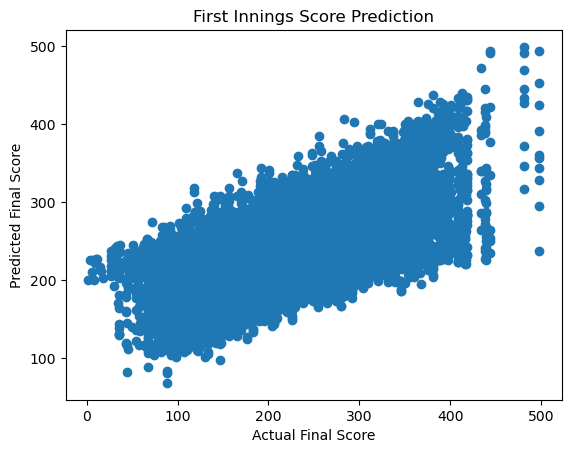

In [7]:

# Score Prediction
X = summary[['cumulative_runs', 'cumulative_wickets', 'over']]
y = summary['final_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Final Score')
plt.ylabel('Predicted Final Score')
plt.title('First Innings Score Prediction')
plt.show()


In [9]:

# Match Winning Prediction
X = summary[['cumulative_runs', 'cumulative_wickets', 'over']]
y = summary['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5149723810446749
              precision    recall  f1-score   support

           0       0.55      0.54      0.55     22386
           1       0.47      0.49      0.48     18890

    accuracy                           0.51     41276
   macro avg       0.51      0.51      0.51     41276
weighted avg       0.52      0.51      0.52     41276



## 🧠 NLP Death Over Bowler Selection

In [11]:

# Simulate commentary
nlp = spacy.load('en_core_web_sm')
bowlers = ['Bumrah', 'Starc', 'Malinga', 'Rabada', 'Nortje']
pitch_types = ['yorker', 'bouncer', 'slower ball', 'short ball', 'full toss']
ground_regions = ['midwicket', 'cover', 'long-off', 'third man', 'square leg']

commentary_data = []
for _ in range(250):
    bowler = random.choice(bowlers)
    pitch = random.choice(pitch_types)
    ground = random.choice(ground_regions)
    commentary = f"{bowler} delivers a {pitch}, batsman mistimes towards {ground}!"
    commentary_data.append(commentary)

def extract_from_commentary(comments):
    data = []
    for comment in comments:
        doc = nlp(comment.lower())
        bowler = None
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                bowler = ent.text
        ground_zone = [g for g in ground_regions if g in comment.lower()]
        pitch_zone = [p for p in pitch_types if p in comment.lower()]
        data.append({'comment': comment, 'bowler': bowler, 'ground_zone': ground_zone, 'pitch_zone': pitch_zone})
    return pd.DataFrame(data)

nlp_df = extract_from_commentary(commentary_data)
nlp_df.head()


,comment,bowler,ground_zone,pitch_zone
0,"Bumrah delivers a short ball, batsman mistimes...",bumrah,[square leg],[short ball]
1,"Nortje delivers a short ball, batsman mistimes...",None,[square leg],[short ball]
2,"Starc delivers a bouncer, batsman mistimes tow...",None,[long-off],[bouncer]
3,"Nortje delivers a yorker, batsman mistimes tow...",None,[midwicket],[yorker]
4,"Rabada delivers a yorker, batsman mistimes tow...",None,[long-off],[yorker]


Top Bowlers:
bowler
bumrah             36
bumrah delivers     6
Name: count, dtype: int64


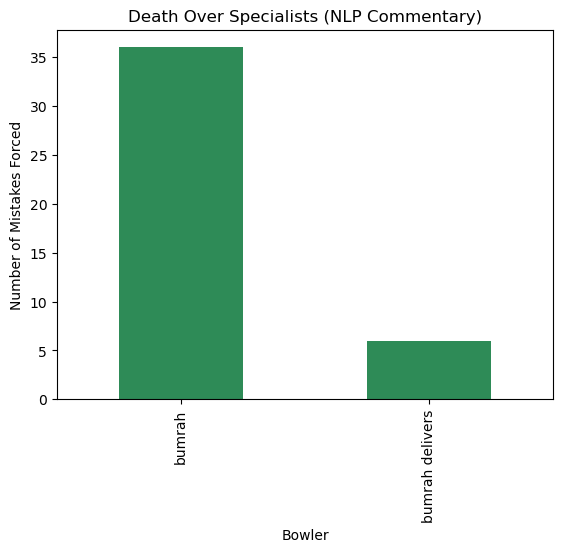

In [13]:

# Bowler ranking
bowler_rank = nlp_df['bowler'].value_counts()
print("Top Bowlers:")
print(bowler_rank)

bowler_rank.plot(kind='bar', color='seagreen')
plt.title('Death Over Specialists (NLP Commentary)')
plt.xlabel('Bowler')
plt.ylabel('Number of Mistakes Forced')
plt.show()
